# Chapter 10
# 10.2 Temperature-Forecasting Example

## 10.2.1 Retrieve Data

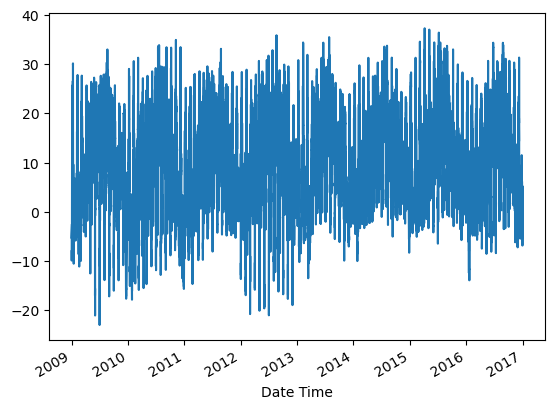

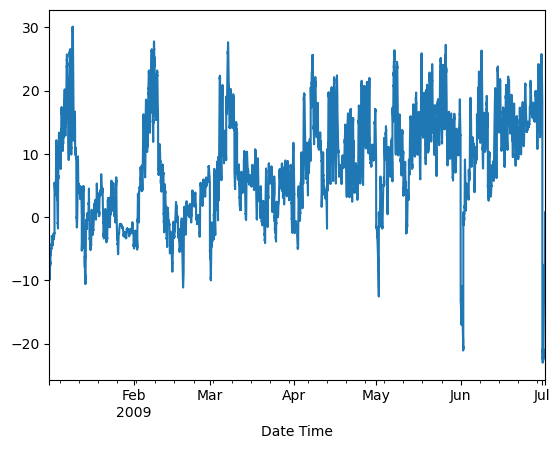

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [11]:
import os
import requests
import zipfile
import pandas as pd
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf

# URL of the file
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
zip_filename = "jena_climate_2009_2016.csv.zip"
csv_filename = "jena_climate_2009_2016.csv"

# Check if the zip file already exists
if not os.path.exists(zip_filename):
    # Download the file
    print(f"Downloading {zip_filename}...")
    response = requests.get(url)
    with open(zip_filename, "wb") as file:
        file.write(response.content)
    print(f"{zip_filename} downloaded.")

# Open the zip file and read the CSV file
with zipfile.ZipFile(zip_filename, "r") as zip_ref:
    with zip_ref.open(csv_filename) as csv_file:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file)

# Display the DataFrame
df["Date Time"] = pd.to_datetime(df["Date Time"], format="mixed")
df = df.set_index("Date Time")
df = df.sort_index()

temps = df.loc[:, 'T (degC)']

#df = df.drop('T (degC)', axis=1)

temps.plot()
plt.show()

temps.loc[temps.index <= (temps.index.values[0] + pd.Timedelta(days=182))].plot()
plt.show()

display(df)

## 10.2.2 Preping data

In [2]:
n_train = int(0.5 * len(df))
n_val = int(0.25 * len(df))
n_test = len(df) - (n_train + n_val)

print("n_train:", n_train)
print("n_val:", n_val)
print("n_test:", n_test)


# Given the last 5 days sampled 1 time hourly, can we predict the temp in 24 hours?
# 1. Normalize the data
def std_scale(df):
    means = df.iloc[:].mean(axis=0)
    stds = df.iloc[:].std(axis=0)
    numerator = df.iloc[:] - means
    denom = stds
    return means, stds, (numerator / denom)

means, stds, df_scaled = std_scale(df)

# 2. Create a dataset object that yields batches of data from the past 5 days along with target 24 hours in the future
# how timeseres_dataset works
## generate array of ints
int_sequence = np.arange(10)

# data -> sequences up until the target
#
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], targets=int_sequence[3:], sequence_length=3, batch_size=2
)
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

# Implementing with our data
sampling_rate = 6
sequence_length = 24 * 5  # 5 days of hourly data
delay = sampling_rate * (
    sequence_length + 24 - 1
)  # target for a sequence is 24 hours from the end of that sequence
batch_size = 256

# Define our ds
# These datasets yield tuples of (samples, targets) where samples is a batch of 256 samples each containing 120 consecutive hours of input data
train_ds = keras.utils.timeseries_dataset_from_array(
    data=df_scaled.iloc[:-delay],
    targets=temps.iloc[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train,
)

val_ds = keras.utils.timeseries_dataset_from_array(
    data=df_scaled.iloc[:-delay],
    targets=temps.iloc[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train,
    end_index=(n_train+n_val),
)

test_ds = keras.utils.timeseries_dataset_from_array(
    data=df_scaled.iloc[:-delay],
    targets=temps.iloc[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=(n_train+n_val),
)

for samples, targets in train_ds:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

n_train: 210225
n_val: 105112
n_test: 105114
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2024-05-20 13:56:15.632079: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-20 13:56:15.632104: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-20 13:56:15.632111: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-20 13:56:15.632129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 13:56:15.632141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-20 13:56:15.702562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


samples shape: (256, 120, 14)
targets shape: (256,)


## 10.2.3 A common sense, non-ml baseline
Before we start using blackbox deep learning to solve, lets use a simple approach. This will help us baseline.

In [3]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * stds.values[1] + means.values[1]
        
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    
    return total_abs_err / samples_seen
  
print(f"Validation MAE: {evaluate_naive_method(val_ds):.2f}")  
print(f"Test MAE: {evaluate_naive_method(test_ds):.2f}")

2024-05-20 13:56:19.273211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 7.41
Test MAE: 7.85


2024-05-20 13:56:22.522436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 10.2.4 Basic ML Model
this doesnt seem to work for tf>2.15

In [4]:
from tensorflow import keras 
from tensorflow.keras import layers

# # Clear old model
# keras.backend.clear_session()

# inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
# x = layers.Dense(64, activation="relu")(inputs)
# x = layers.Dense(16, activation="relu")(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense(1, activation='linear')(x)
# model = keras.Model(inputs, outputs)

  
# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_dense.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# display(
#     keras.utils.plot_model(
#         model,
#         show_shapes=True,
#         show_layer_activations=True,
#         show_trainable=False,
#         dpi=75,
#         expand_nested=False,
#         rankdir="LR",
#         show_dtype=False,
#         show_layer_names=True,
#     )
# )

# history = model.fit(train_ds,
#                     epochs=10,
#                     validation_data=val_ds,
#                     callbacks=callbacks)

# loss = history.history["mae"]
# val_loss = history.history["val_mae"]
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training MAE")
# plt.plot(epochs, val_loss, "r--", label="Validation MAE")
# plt.title("Training and validation MAE")
# plt.legend()
# plt.show()

## 10.2.5 1D conv model
I could not get the last to work, lets try convolution -> this is kind of like rolling calcs

In [5]:
# Clear old model
keras.backend.clear_session()

inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

if not os.path.exists("jena_conv.keras"):
    callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)]
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "r--", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()
else:
    model = keras.models.load_model("jena_conv.keras")
    print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")


2024-05-20 13:56:22.894919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-20 13:56:22.895590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


407/407 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 59.7688 - mae: 6.2751
Test MAE: 6.26


## 10.2.6 A first recurrent baseline
There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular. We’ll see in a minute how these models work, but let’s start by giving the LSTM layer a try.

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 98.0755 - mae: 7.9778 - val_loss: 62.2254 - val_mae: 6.4554
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 71.5785 - mae: 6.7803 - val_loss: 61.6018 - val_mae: 6.4141
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 70.4386 - mae: 6.7133 - val_loss: 62.2192 - val_mae: 6.4425
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 69.0149 - mae: 6.6270 - val_loss: 60.4989 - val_mae: 6.3192
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 67.3789 - mae: 6.5151 - val_loss: 60.2487 - val_mae: 6.3379
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 65.7500 - mae: 6.4152 - val_loss: 60.9375 - val_mae: 6.3632
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 64.6463 - mae: 6.3596 - val_loss: 61.7174 - val_mae: 6.3379
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 64.5179 - mae: 6.3324 - val_loss: 61.8673 - val_mae: 6.3893
Epoch 9/10
821/821 ━━━━━

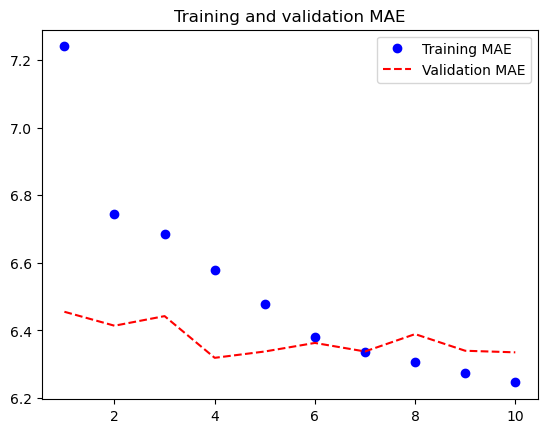

  1/407 ━━━━━━━━━━━━━━━━━━━━ 1:31 224ms/step - loss: 66.3494 - mae: 6.5592

2024-05-20 13:59:41.377356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


407/407 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 64.7625 - mae: 6.5154
Test MAE: 6.52


In [6]:
# Clear old model
keras.backend.clear_session()

# LTSM
inputs = keras.Input(shape=(sequence_length, df_scaled.shape[-1]))
x = layers.LSTM(units=16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_ltsm.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=callbacks)

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "r--", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

model = keras.models.load_model("jena_ltsm.keras")
print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")